In [3]:
import pandas as pd
import numpy as np
import csv
from dh2loop import dh2l
import psycopg2

In [4]:
%run -i "dh2l_config.py"

Default parameters loaded from dh2l_config.py:
#Database Files
data_path='../data/'
wamex_path='../data/wamex/'
collar_file=wamex_path+'collar.csv'
collarattr_file=wamex_path+'collarattr.csv'
dhsurvey_file=wamex_path+'dhsurvey.csv'
dhsurveyattr_file=wamex_path+'dhsurveyattr.csv'
dhgeology_file=wamex_path+'dhgeology.csv'
dhgeologyattr_file=wamex_path+'dhgeologyattr.csv'

#Thesauri
rl_maxdepth_dic_file= wamex_path+'rl_maxdepth_dic.csv'
survey_dic_file=wamex_path+'survey_dic.csv'
dic_attr_col_lithology_file=wamex_path+'dic_att_col_lithology.csv'
dic_attr_val_lithology_file=wamex_path+'dic_attr_val_lithology_filter.csv'
cleanup_lithology_file=wamex_path+'cleanup_lithology.csv'
litho_dic_file=wamex_path+'litho_dic_1.csv'
CET_hierarchy_dico_file=wamex_path+'hierarchy_dico.csv'

#ExportFiles
export_path='../data/export/'
DB_Collar_Export=export_path+'DB_Collar_Export.csv'
DB_Survey_Export=export_path+'DB_Survey_Export.csv'
DB_Survey_Export_Calc=export_path+'DB_Survey_Export_Calc.csv'
CET_Lith

## Geology

In [5]:
geology=pd.read_csv (DB_Lithology_Export_Calc)
geology=geology.rename(columns={"CollarID": "collarid", "FromDepth": "fromdepth", "ToDepth": "todepth", "CET_Litho":"comp lithology"})
geology['collarid'] = geology['collarid'].astype(int)
geology.head()

,Unnamed: 0,Company_ID,collarid,fromdepth,todepth,Company_LithoCode,Company_Litho,comp lithology,Score,Level_3,...,xbt,ybt,zbt,xmt,ymt,zmt,xet,yet,zet,Unnamed: 20
0,36,3050,548917,0.0,19.0,Fgd,granodiorite,granodiorite,101,granodiorite,...,514164.694405,6.747200e+06,331.316000,514168.725634,6.747200e+06,322.722624,514170.979020,6.747200e+06,313.520157,NaN
1,37,3050,548917,19.0,27.0,Fgd,granodiorite,granodiorite,101,granodiorite,...,514170.979020,6.747200e+06,313.520157,514171.204428,6.747200e+06,309.528639,514171.204428,6.747200e+06,305.528639,NaN
2,38,3050,548917,27.0,31.0,Fgd,granodiorite,granodiorite,101,granodiorite,...,514171.204428,6.747200e+06,305.528639,514171.204428,6.747200e+06,303.528639,514171.204428,6.747200e+06,301.528639,NaN
3,39,3050,548917,31.0,39.0,Fgd,granodiorite,granodiorite,101,granodiorite,...,514171.204428,6.747200e+06,301.528639,514171.204428,6.747200e+06,297.528639,514171.204428,6.747200e+06,293.528639,NaN
4,40,3050,548917,39.0,41.0,Fgd,granodiorite,granodiorite,101,granodiorite,...,514171.204428,6.747200e+06,293.528639,514171.204428,6.747200e+06,292.528639,514171.204428,6.747200e+06,291.528639,NaN


## Geochemistry

#### To extract geochemistry data make sure you are connected to UWA network

In [ ]:
minlong=116.5
maxlong=117.2
minlat=-29.5
maxlat=-28.8
bounds=(minlong,maxlong,minlat,maxlat)  #query bounds

query = """SELECT  a.id, a.dhgeochemistryid, s.collarid, c.holeid, c.companyholeid, s.fromdepth, s.todepth,  a.attributecolumn, a.attributevalue
FROM public.dhgeochemistryattr AS a 
INNER JOIN public.dhgeochemistry AS s ON a.dhgeochemistryid = s.id
INNER JOIN public.collar AS c ON s.collarid = c.id
WHERE(longitude BETWEEN %s  AND %s AND latitude BETWEEN %s AND %s)
ORDER BY c.companyid ASC
"""
conn = psycopg2.connect(host="130.95.198.59", port = 5432, database="gswa_dh", user="postgres", password="loopie123pgpw")
cur = conn.cursor()
cur.execute(query, bounds)
dhchemistryattrygsb = pd.DataFrame(cur.fetchall())
cur.close()
conn.close()

In [ ]:
dhchemistryattrygsb.columns = ['id', 'dhgeochemistryid', 'collarid', 'holeid', 'companyholeid', 'fromdepth', 'todepth',  'attributecolumn', 'attributevalue']
unique= dhchemistryattrygsb['attributecolumn'].unique().tolist()
print(unique)

In [ ]:
dhchemistryattrygsb= dhchemistryattrygsb[dhchemistryattrygsb['attributecolumn'].isin([
                                                                                    'Al2O3_pct',
                                                                                    'CaO_pct',
                                                                                    'Cu_ppm',
                                                                                    'Fe_pct',
                                                                                    'K2O_pct',
                                                                                    'Mgo_pct',
                                                                                    'MnO_pct',
                                                                                    'Na2O_pct',
                                                                                    'P_pct',
                                                                                    'Pb_ppm',
                                                                                    'S_pct',
                                                                                    'SiO2_pct',
                                                                                    'Zn_ppm'
                                                                                    ])]

In [ ]:
dhchemistryattrygsb = pd.pivot_table(dhchemistryattrygsb, values='attributevalue', index=['dhgeochemistryid', 'collarid', 'holeid', 'companyholeid', 'fromdepth', 'todepth'],
                    columns=['attributecolumn'], aggfunc='first')
dhchemistryattrygsb.to_csv('../data/export/DB_Geochemistry_Export.csv')

In [ ]:
geochemistry=pd.read_csv ('../data/export/DB_Geochemistry_Export.csv')

In [ ]:
dh2l.merge(geology,geochemistry,'join',tol=0.01,clean=True)

In [ ]:
join=pd.read_csv ('../data/export/join.csv')
print(join)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from striplog import Legend, Lexicon, Interval, Component, Striplog

In [ ]:
legend = Legend.builtin('NSDOE')
lexicon = Lexicon.default()
#lexicon
#lexicon.synonyms

In [ ]:
csv_string=join[(join['collarid']==1233095)]
csv_string=csv_string[["fromdepth", "todepth", "comp lithology"]]
csv_string=csv_string.rename(columns={"fromdepth": "top", "todepth": "base", "comp lithology": "comp lithology"})
csv_string=csv_string.fillna('NaN')
csv_string=csv_string.to_csv(sep=',', index=False)
print(csv_string)

In [ ]:
strip = Striplog.from_csv(text=csv_string, lexicon=lexicon)

In [ ]:
strip
#strip[0]
#strip.unique
#strip.find_gaps() or "No gaps!"
#strip.thinnest()

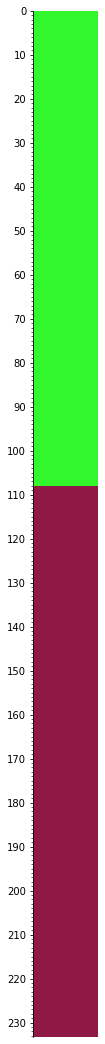

In [40]:
strip.plot()
#strip.plot(legend=legend, aspect=5)

In [41]:
l = u"""colour, width, component lithology
#F7E9A6, 3, Sandstone
#FF99CC, 2, CYST
#86F0B6, 5, Conglomerate
#F2FF42, 4, Sand
#FFE040, 4, Calksilicate
#FF4C4A, 2, Pegmatite 
#363434, 1, Gneiss 
#664A4A, 1, Clay
#FF99CC, 1, Granite"""

In [42]:
#legend = Legend.from_csv(text=l)
#legend[:10]
legend=Legend.default()

In [44]:
pruned = strip.prune(limit=40.0, keep_ends=True)
annealed = pruned.anneal()
merged = annealed.merge_neighbours()

In [47]:
from welly import Curve
todepth=join['todepth'].to_numpy()
density=join['Fe_pct'].to_numpy()
density_curve = Curve(data=density, basis=todepth)
strip.extract(density_curve, basis=todepth, name='Fe_pct')

example=join['K2O_pct'].to_numpy()
curve = Curve(data=example, basis=todepth)
strip.extract(curve, basis=todepth, name='K2O_pct')
strip[1]

Interval({'top': Position({'middle': 1.0, 'units': 'm'}), 'base': Position({'middle': 2.0, 'units': 'm'}), 'description': '', 'data': {'Fe_pct': array([40.16]), 'K2O_pct': array([0.006])}, 'components': [Component({'lithology': 'banded_iron_formation'})]})

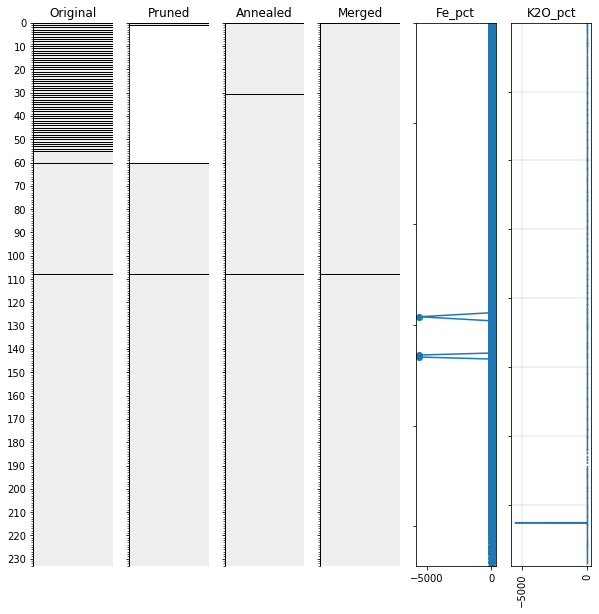

In [49]:
fig, axs = plt.subplots(ncols=6, figsize=(10, 10))

axs[0] = strip.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
#axs[4]=density_curve.plot(ax=axs[4])
axs[4].plot(density, todepth,'-o')
axs[4].set_ylim(269.9, 0)
axs[4].set_yticklabels([])
axs[4].set_title('Fe_pct')
axs[5]=curve.plot(ax=axs[5])
axs[5].set_yticklabels([])
axs[5].set_title('K2O_pct')
plt.show()